# View final results  
**Use Case:** AM parts from Xuan Zhang    

Author: Aniket Tekawade, Argonne National Laboratory, atekawade@anl.gov  

https://tomobank.readthedocs.io/en/latest/source/data/docs.data.spheres.html

**NOTE** This notebook contains jupyter widgets that may not display unless you re-rerun the notebook.  

In [1]:
%matplotlib notebook

import sys
import os
import numpy as np
import pandas as pd
import glob
import h5py
import time

from scipy.ndimage.filters import median_filter
from ImageStackPy import Img_Viewer as VIEW

import matplotlib.pyplot as plt
import matplotlib as mpl

# from ct_segnet.data_utils import data_io
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
from ct_segnet import seg_utils
from tqdm import tqdm

from ct_segnet.data_utils import patch_maker_3D as PM3D
from ct_segnet.data_utils.data_io import Parallelize
from ct_segnet.seg_utils import Segmenter

from ImageStackPy import ImageProcessing as IP

# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display, update_display
from ipyfilechooser import FileChooser
from skimage.io import imread
from tomopy.misc.corr import remove_ring

def text_width(wd):
    return Layout(width = "%ipx"%wd)

In [2]:
default_path = '/data02/MyArchive/AM_part_Xuan/data/' #ensure this path matches where your data is located.
seg_path = '/data02/MyArchive/AM_part_Xuan/seg_data/'

## Try out different patch-extraction strategies  
You select two parameters:  
n_patches or max_patches - this is a tuple (y,x). y is the number of patches along y, etc.  
overlap - this the number of pixels overlapping between patches. Just pick 20 and go with it.  
**Note to user:** In CTSegNet, the arguments max_patches and n_patches mean the same thing. In the future, the alias max_patches will be removed.  

**IMPORTANT** Notebook widgets may not display correctly unless you re-run the notebook at your end.  

FileChooser(path='/data02/MyArchive/AM_part_Xuan/data', filename='', title='HTML(value='', layout=Layout(displ…

['',
 'Dataset shape: (1102, 4200, 4200)',
 'Dataset size: 38.88 GB',
 'Chunk shape: (32, 123, 123)',
 'Slice size along 0: 35.28 MB',
 'Slice size along 1: 9.26 MB',
 'Slice size along 2: 9.26 MB']

<IPython.core.display.Javascript object>


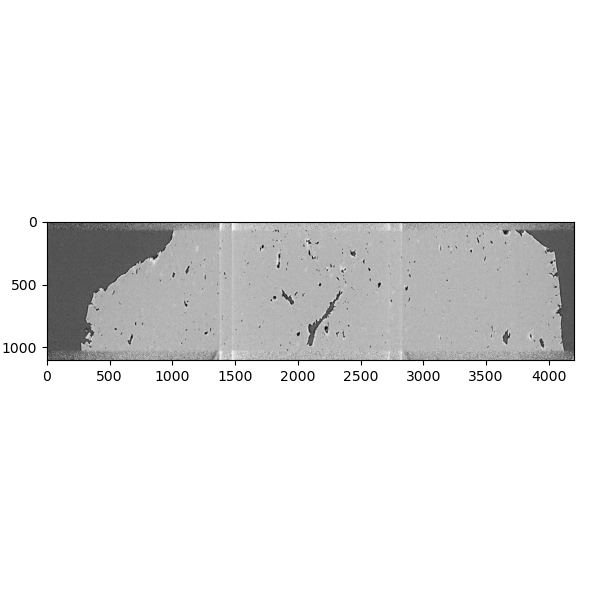

In [4]:
# file selector
fc = FileChooser(default_path)
btn_fc = widgets.Button(description = "Load DataSet")

display(fc)
display(HBox(children = [btn_fc]))
display("", display_id = "007")

def load_ds(obj):
    global ds, ds_seg
    ds = DataFile(fc.selected, data_tag = "data", tiff = False, VERBOSITY = 0)
    filename = os.path.split(fc.selected)[-1].split('_rec_1x1_uint16.hdf5')[0]
    seg_fpath = os.path.join(seg_path, filename, filename + '_GT.hdf5')
    if os.path.exists(seg_fpath):
        ds_seg = DataFile(seg_fpath,\
                          data_tag = 'SEG', tiff = False, VERBOSITY = 0)
    else:
        ds_seg = None
    str_out = ds.show_stats(return_output = True).split('\n')
    "<br>".join(str_out)
    update_display(str_out, display_id = "007")
    
    return

btn_fc.on_click(load_ds)

# slice reader
text_axis = widgets.IntText(description = "axis", min = 0, max = 2, value = 0, layout = text_width(150))
slider = widgets.IntSlider(description = "slider", min = 0, value = 0, step = 1)
display(HBox(children = [text_axis, slider]))

btn_seg = widgets.Button(description = "Segment")
load_btn_1 = widgets.Button(description = "Load Image")
checkbox_edge = widgets.Checkbox(description = "Edge Plot", value = True)
display(HBox(children = [load_btn_1, btn_seg, checkbox_edge]))

fig, ax = plt.subplots(1,1, figsize = (6,6))
fig.tight_layout()

def load_image(obj):
    
    img = ds.read_slice(axis = text_axis.value, slice_idx = slider.value)
    ax.clear()
    ax.imshow(img, cmap = 'gray')
    return

def seg_shower(obj):
    
    if ds_seg is None: return
    seg_img = ds_seg.read_slice(axis = text_axis.value, slice_idx = slider.value)
    img = ds.read_slice(axis = text_axis.value, slice_idx = slider.value)
    if checkbox_edge.value:
        viewer.edge_plot(img, seg_img, ax)
    else:
        viewer.seg_plot(img, seg_img, ax)
#     fig.tight_layout()
    return

btn_seg.on_click(seg_shower)
load_btn_1.on_click(load_image)

def update_slider(obj):
    slider.max = ds.d_shape[text_axis.value]
    
    if text_axis.value == 0:
        i, j = 1,2
    elif text_axis.value == 1:
        i, j = 0,2
    elif text_axis.value == 2:
        i, j = 0,1
    
    return
text_axis.observe(update_slider)
btn_fc.on_click(update_slider)


The end!